<a href="https://colab.research.google.com/github/AlisonJD/RTACourse/blob/main/Data_Storage_Inside_the_Analytics_Database.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)

% cd "/content/gdrive/My Drive/Colab Notebooks/Tinybird"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Colab Notebooks/Tinybird



| <a href="https://www.tinybird.co/" target="_parent"><img src="https://uploads-ssl.webflow.com/6048c50adefe73fe3bc6c51b/6048eb77ca9dde7b528e4354_Logo%20Navbar.svg" alt="Tinybird"/></a>      | Principles of Real-Time Analytics Course    |
| :------------- :| :------------- :|




In [ ]:
!pip install tinybird-cli -q

In [ ]:
!tb auth

Copy the admin token from https://ui.tinybird.co/tokens and paste it here: 
** Auth successful! 
** Configuration written to .tinyb file, consider adding it to .gitignore


#Data Storage Inside the Analytics Database
Ingesting data != storing data. Storage is the key to getting fast queries. Typically the data is organised hierarchically into databases, in each database there are tables which are themselves divided into partitions and in each partition there are columns.

Let’s look at some concepts about data storage, analyse different ways to store data and see how that relates to the hardware and the OS.


##Schemas
In order to do fast analysis you (and your database) need to know as much as possible about the data. Data should be as homogeneous as possible to use the least possible code to process it and take the least space possible.

That’s what a schema provides: a way to know what data types we are working with and ensure that data is homogeneous. Not only that, it’s the way you tell the database how your data is and will be.

The schema describes the data, for example, this table has N columns with names A, B, C, or that column is a 32 bit integer, or the table is sorted by values in column D.


##All in Memory
If you want to run real-time analytics with a reasonable response time then everything you query should be in memory. Don’t expect to run real-time analytics with your data stored in S3 (or similar) or with a system that needs to spin machines/processes to run the query. As we saw before, disks are usually way slower than memory.

Does that mean your whole dataset needs to fit in memory? Not really, most of the time the part of the dataset you use is just a subset. Also, there are compression techniques that improve how much data you can fit in memory.

Typically you query 20% of the data in 80% of the queries and that makes things easier. You should underprovision and measure, this will save a lot of money on hardware.

If your dataset does not fit in memory, you can:
- Shard or replicate your data in more than one machine.
- Use faster disks so that the performance for large queries is nearly as fast as if the data were in memory.


##Network/Hard Disk Speed vs CPU
As we said, CPU is way faster than memory and therefore orders of magnitude faster than disks and the network. So what’s the best way to balance that situation? If we could send to the CPU part of the job that the memory or the network have to do then we would make the bottleneck a little bit wider. Fortunately, we have a tool to do that: compression. 

Storing and sending compressed data moves part of the work to the CPU and we usually gain 4-10x on memory bandwidth. So, as a general rule, use compression when storing and transferring data. There are a few use cases where compression is worse but in general it is always a good idea to enable it.


##Why Compress?
You could compress every byte you store using the same algorithm and that would be a gain in performance but not every kind of data compresses in the same way. Compressors are good for removing redundancies but they aren’t magic, you need to choose a compressor and make the job easier for them with codecs.

For example, let’s analyze an `Int32` column that has this data:

`1, 2, 5, 6, 7, 8, 10, 11, 11`

This can be compressed by running a simple delta codec to get

`1, 1, 3, 1, 1, 1, 2, 1, 0`

The second array is far easier to compress and we just have to undo the delta codec (which is pretty cheap) when working with that column.

Take a look at the following images on two different kinds of data. The Y axis shows the data size (less is better).

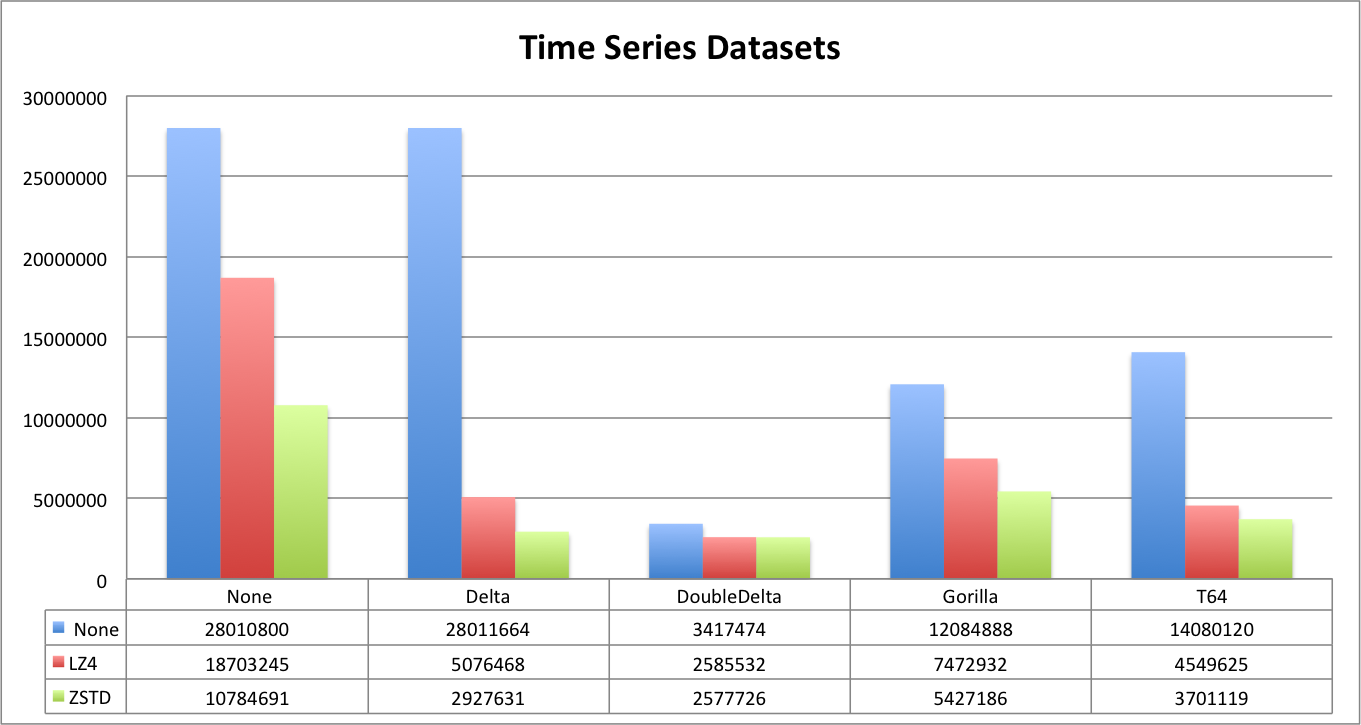

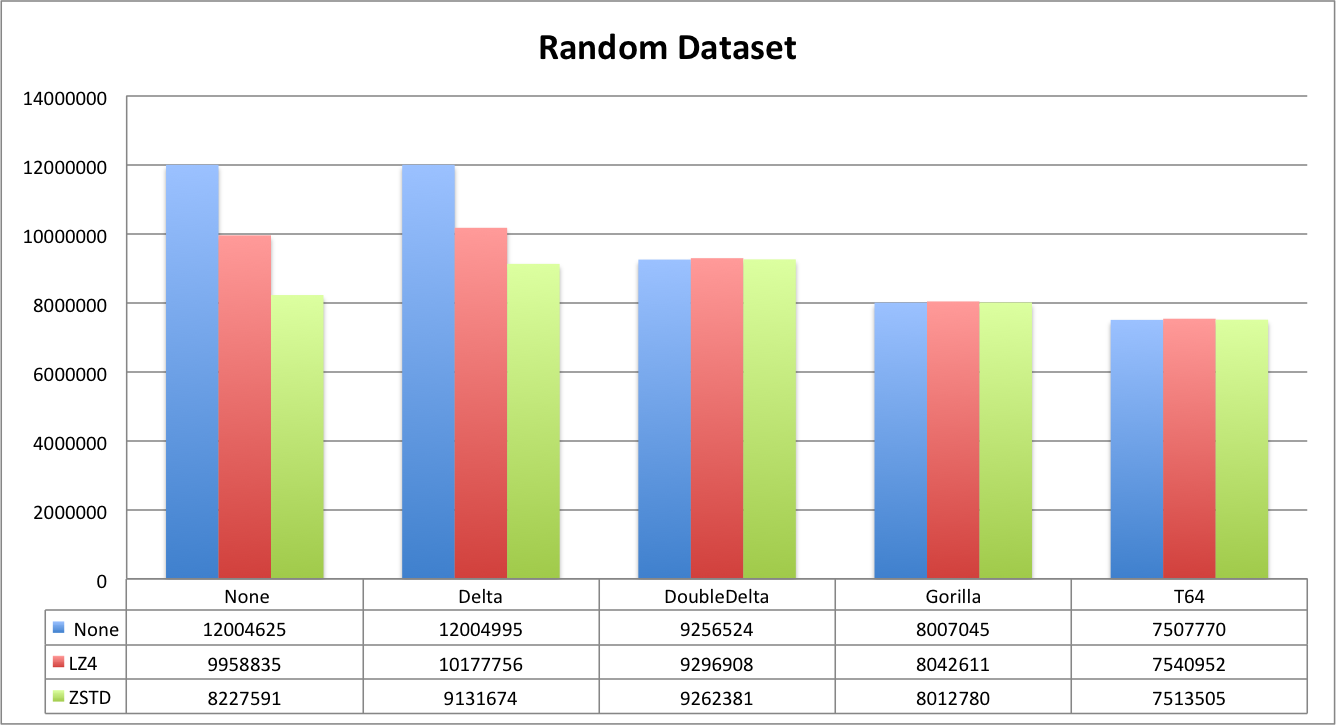

These images are from [New Encodings to Improve ClickHouse Efficiency](https://altinity.com/blog/2019/7/new-encodings-to-improve-clickhouse), an excellent article about codecs and compression methods.

So you should think about what compression method is best for your column (and the order) and use the right one for what you want to achieve. Sometimes you want faster queries but by picking the right one you could save money on storage using a more aggressive compressor that takes more CPU but reduces the size.

##How and When to Compress
Compression and codecs types can be chosen based on:
 - Ratio compression vs speed
 - Use cases that they are optimized for

LZ4 is a really fast codec but ZSTD usually compresses more in exchange for using more CPU.  The Delta codec is optimized for data that changes slowly or has any kind of autocorrelation. The columns you use less could be compressed with ZSTD (less disk space) and the columns you use a lot could be compressed with LZ4 (fast).

In order to know what codec is the right one you have to benchmark it and try to pick the one that saves enough memory bandwidth and doesn't kill CPU performance. Bear in mind that compression and codecs don’t come for free, they increase the insertion times. That’s not usually a problem but is something that you need to measure.

We almost always use LZ4 for real-time analytics, it has the best compression/speed ratio. Let's see why by comparing the speed for a simple operation.


####Choose the Best Compression
Here we create a table test_codecs with three columns containing random values,

 - Column 1 - no compression (1x)
 - Column 2 - LZ4: faster decompression but worse compression ratio (6.1x)
 - Column 3 - ZSTD: slower decompression but better compression ratio (11.5x)

The query  sums over 100 M rows with the three different codecs (max_threads=4) using ClickHouse. 


```
ClickHouse
:) 

CREATE TABLE test_codecs
(
    `n` Int32,
    `lz4` Int32 CODEC(LZ4),
    `zstd` Int32 CODEC(ZSTD(4))
)
ENGINE = MergeTree
ORDER BY tuple()

:) 

INSERT INTO test_codecs (n) SELECT 1000 + ((rand(1) % 1000) * ((rand(2) % 10) = 0))
FROM numbers(200000000)
SETTINGS max_block_size = 5000000

0 rows in set. Elapsed: 4.604 sec. Processed 200.00 million rows, 1.60 GB (43.44 million rows/s., 347.56 MB/s.)

:) SET max_threads = 4

:) SELECT sum(n) FROM test_codecs

┌───────sum(n)─┐
│ 104992911662 │
└──────────────┘

1 rows in set. Elapsed: 0.077 sec. Processed 100.00 million rows, 400.00 MB (1.30 billion rows/s., 5.20 GB/s.)

:) SELECT sum(lz4) FROM test_codecs

┌─────sum(lz4)─┐
│ 104992911662 │
└──────────────┘

1 rows in set. Elapsed: 0.069 sec. Processed 100.00 million rows, 400.00 MB (1.45 billion rows/s., 5.81 GB/s.)

:) SELECT sum(zstd) FROM test_codecs

┌────sum(zstd)─┐
│ 104992911662 │
└──────────────┘

1 rows in set. Elapsed: 0.120 sec. Processed 100.00 million rows, 400.00 MB (835.53 million rows/s., 3.34 GB/s.)
```

LZ4 (0.069 sec)  wins over the uncompressed version (0.077 sec).  ZSTD (0.120 sec) is worse in this case. 

Setting `max_threads = 1`, LZ4 speed is the same as no compression but uses 6x less space.

##The Right Type for the Job.
Some tips on how to choose the right type for your data:



###Tip 1: Choose the Data Type needing Least Storage
Don’t use an Int64 if an Int8 is enough. It saves memory (less bytes to store the same information) and processing power. This is something to apply all the time. Decades ago developers carefully chose data types because memory and disk space were really limited (remember [Y2K](https://en.wikipedia.org/wiki/Year_2000_problem)) but we tend to forget this with more powerful machines, more memory and bigger disks.

We can see this with a simple ClickHouse example of calculating an average over 20 M numbers with data types Int8 and Int64

```
ClickHouse
:) 

CREATE TABLE t_int8
(
    `a` Int8
)
ENGINE = MergeTree
ORDER BY a

:)

CREATE TABLE t_int64
(
    `a` Int64
)
ENGINE = MergeTree
ORDER BY a

:)

INSERT INTO t_int8 SELECT rand() % 100
FROM numbers(20000000)

-- same data into t_int64

:) 

INSERT INTO t_int64 SELECT a
FROM t_int8

-- run a simple query

:) 

SELECT avg(a)
FROM t_int8

┌──────avg(a)─┐
│ 49.50872795 │
└─────────────┘

1 rows in set. Elapsed: 0.014 sec. Processed 20.00 million rows, 20.00 MB (1.44 billion rows/s., 1.44 GB/s.)

:)

SELECT avg(a)
FROM t_int64

┌──────avg(a)─┐
│ 49.50872795 │
└─────────────┘

1 rows in set. Elapsed: 0.022 sec. Processed 20.00 million rows, 160.00 MB (894.89 million rows/s., 7.16 GB/s.)
```


###Tip 2: Use Arrays Instead of Denormalizing
In some cases, arrays are much better than denormalizing. For example, imagine you have user events for a session and you save all the (x, y) coordinates, instead of saving an extra column, or a separate table that you need to join, you can do:

```
x Array(Int32),
y Array(Int32)
```
This approach is used here to store the ingredients, directions and  named-entity recognition in a table of ClickHouse Recipes, which is created as a datasource in Tinybird [here](https://colab.research.google.com/github/AlisonJD/RTACourse/blob/main/ClickHouse_Recipes.ipynb).




In [ ]:
!tb sql "SELECT * FROM recipes LIMIT 1"

--------------------------------------------------------------------------------
title: oatmeal apple crisp Recipe adrndack
ingredients: ['5 apples; peeled, cored and cubed', '1/8 teaspoon allspice', '1/8 teaspoon cloves', '1/8 teaspoon nutmeg, freshly ground', '1 tablespoon honey', '1/4 cup butter or margarine; chilled and cut into pieces', '1/2 cup flour', '1/2 cup old fashioned oats', '1/2 cup brown sugar', '1/2 teaspoon cinnamon', '1 teaspoon vanilla extract']
directions: ['preheat oven to 375 degrees fahrenhiet.', 'grease an 8x8 baking dish.', 'combine brown sugar, flour, oats, cinnamon and vanilla extract.', 'add butter.', 'with a fork, mash together until the mixture forms moist clumps.', 'keep chilled while preparing apples.', 'in a medium bowl combine apples, allspice, cloves, nutmeg and honey.', 'toss well to coat.', 'place apples in baking dish.', 'sprinkle topping over apples.', 'bake until filling bubbles thickly and topping is crisp and deep golden brown, about 40 minutes

In [ ]:
!tb sql "SELECT title, NER FROM recipes WHERE has(NER, 'cheddar cheese') LIMIT 10"

--------------------------------------------------------------------------------
title: zucchini stuffed
NER: ['zucchini', 'salt', 'rice', 'carrot', 'cheddar cheese', 'sesame oil', 'parmesan cheese']
--------------------------------------------------------------------------------
title: jalapeno corn bread
NER: ['cornmeal', 'flour', 'sugar', 'baking powder', 'baking soda', 'salt', 'egg', 'corn', 'milk', 'cheddar cheese', 'butter']
--------------------------------------------------------------------------------
title: juicy cheeseburgers
NER: ['ground beef', 'ground pork', 'onion soup', 'tomato', 'bbq sauce', 'bacon', 'cheddar cheese', 'red onion', 'lettuce', 'garlic', 'onion', 'egg', 'sesame hamburger']
--------------------------------------------------------------------------------
title: *Turkey Enchiladas
NER: ['turkey cooked', 'sour cream', 'cheddar cheese', 'salt', 'corn', 'corn oil', 'green chili peppers', 'garlic', 'olive oil', 'onions', 'salt', 'oregano', 'water', 'tomatoes']
-

If the database you use is advanced enough you could have not only arrays but also maps.

###Tip 3: Use Special Data Types
Use special types like LowCardinality, bitmaps or intermediate aggregation types if possible.

The table of recipes uses LowCardinality for the source column since the recipes come from only two locations.

In [ ]:
!tb sql "SELECT count(title), source FROM recipes GROUP BY source"

----------------------------
| count(title) | source    |
----------------------------
|       588044 | Recipes1M |
|      1643097 | Gathered  |
----------------------------


Memory bandwidth is usually key so save as much as possible.

##Order Data Based on Access Patterns
When you store data in a transactional database you usually don’t decide the order (even though most of those databases have a way to cluster the data) but with large datasets this is critical.

But wait, what does data order mean? Memory, disk and so on are devices where data is stored linearly (not totally true but it’s good enough). So in the same way that in Excel you sort your table using some of the columns, in this situation you need to do the same. So some columns will be sorted and others will follow that order.

You need to decide the data order before storing the data.

Look at the schema of the New York City Taxi Trip dataset, which is created as a data source in Tinybird [here](https://colab.research.google.com/github/AlisonJD/RTACourse/blob/main/New_York_City_Taxi_Trip_Datasets.ipynb).


In [ ]:
!cat datasources/taxi.datasource


DESCRIPTION amending schema that would be automatically generated
SCHEMA >
    `vendorid` Int16,
    `tpep_pickup_datetime` DateTime,
    `tpep_dropoff_datetime` DateTime,
    `passenger_count` Nullable(Int16),
    `trip_distance` Float32,
    `ratecodeid` Nullable(Int16),
    `store_and_fwd_flag` String,
    `pulocationid` Int32,
    `dolocationid` Int32,
    `payment_type` Nullable(Int16),
    `fare_amount` Float32,
    `extra` Float32,
    `mta_tax` Float32,
    `tip_amount` Float32,
    `tolls_amount` Float32,
    `improvement_surcharge` Float32,
    `total_amount` Float32,
    `congestion_surcharge` Nullable(Float32)

ENGINE "MergeTree"
ENGINE_PARTITION_KEY "toMonth(tpep_pickup_datetime)"
ENGINE_SORTING_KEY "tpep_pickup_datetime"


What’s the right data order? There isn’t one. It depends on your access patterns. If we are going to query data using the date, ordering the data by `tpep_pickup_datetime` sounds like a good option. However, that means `fare_amount` is likely not to be sorted because it’s not correlated with the pickup location.

Obviously, you can sort by many columns but this will not solve the problem.

##Use Indexes for Large Datasets
Traditionally, in transactional databases, indexes use a B-tree or similar to know where a row is located. So when you do

`SELECT * FROM table WHERE id = 2`

if the `id` column has an index, the database uses it and instead of doing a linear search (full scan) it goes directly to the part of the disk where it is stored.

Easy, with large data we could do the same, right? B-tree and similar algorithms take a lot of memory and with a large amount of data you can’t address every single row. You actually don’t need to; that’s why range indexes were created. They store information about blocks, so if your data is sorted you can split it into blocks and store max/min (or other statistics). This means to fetch only the desired blocks you simply query over a range, which is trivial.

Partitioning is something some big data systems also use. They split the data into several partitions (usually different files) so that it’s easier to access. The principle is the same. This is an example
 from the documentation for [Parquet files](https://spark.apache.org/docs/latest/sql-data-sources-parquet.html). "In a partitioned table, data are usually stored in different directories, with partitioning column values encoded in the path of each partition directory."

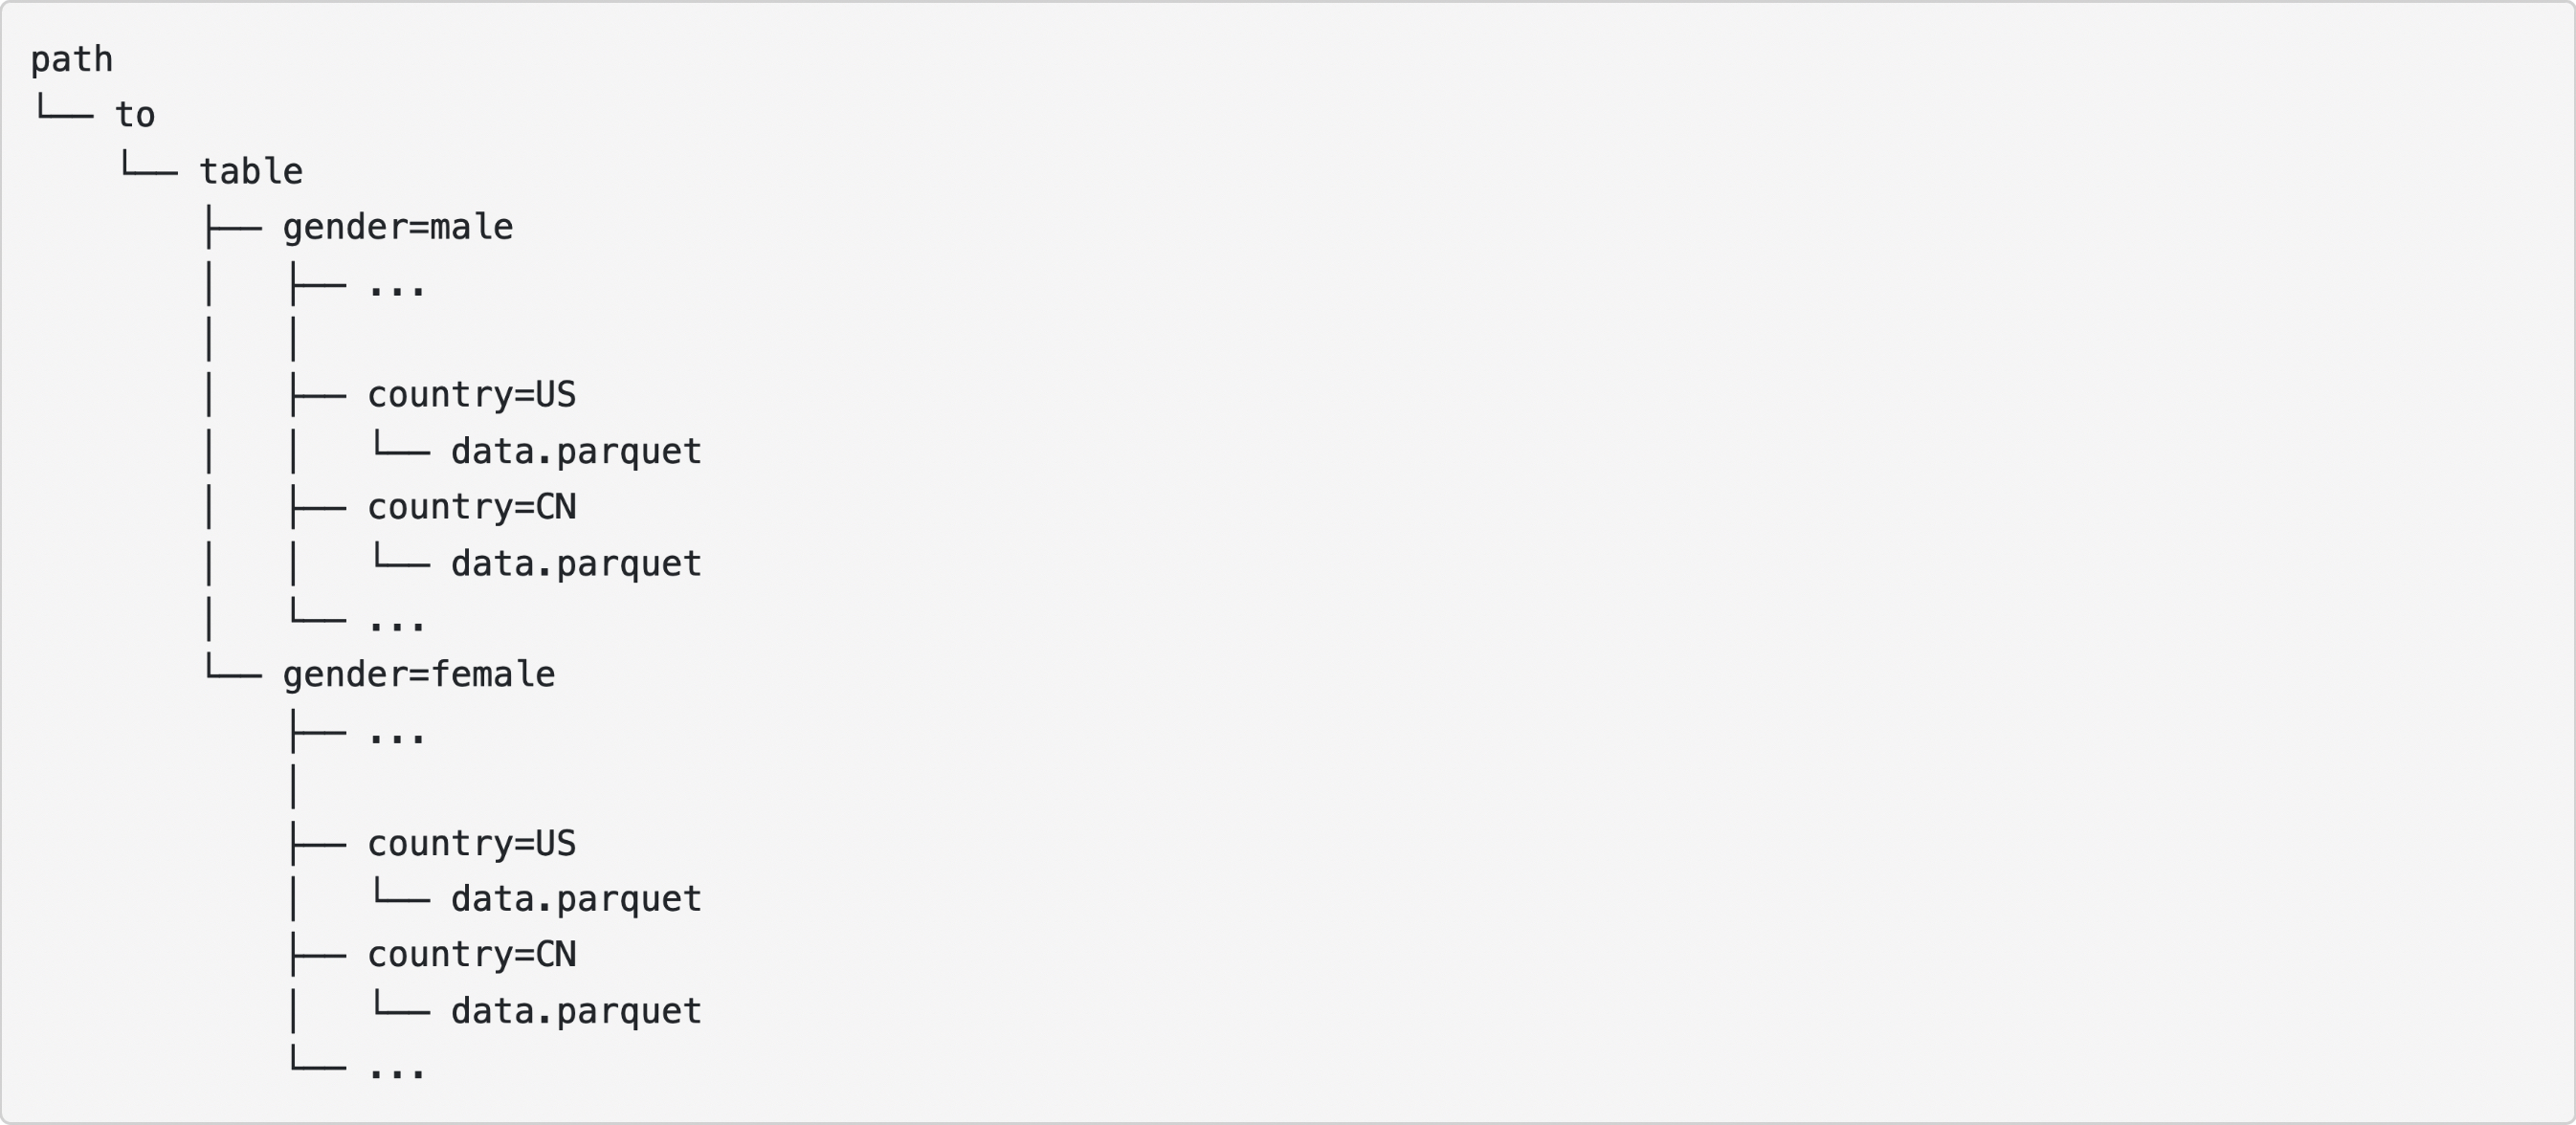

What happens if I want to have indexes on more than one column? You can sort by those columns but obviously that will only work with 2 or 3 columns. You do, however, always have the option of storing the same data in different orders. This sounds like overkill but it’s not.

There are other kinds of block based indices based on Bloom filters that work with unsorted data that work when the selectivity is really high.


##Inserting and Storing
When we talk about real-time it doesn't only mean we are able to run queries in less than X, it also means we are able to see data generated a few seconds ago (not hours, not days). New data should be prepared so that it can be queried as it arrives: it needs to be sorted and indexes should be created. 

If the sorting, indexes, compression codecs and so on are hard to execute there might be an impact. Depending on the architecture of the database doing things in batches may be needed. 

Ideally, fewer inserts, already sorted and using the optimal format are the right thing to do. In an ideal world, data should be prepared on a different machine to the one executing queries. We usually parse, sort and transform the data to the internal database representation format before sending it to the database.
